In [1]:
#  !pip install torchinfo


In [20]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader 
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




CLASS_LABELS  = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]  # it's wrong


In [21]:
NUM_CLASSES = len(CLASS_LABELS)
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

In [22]:
label_dict

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sadness',
 6: 'Surprise'}

In [23]:
df = pd.read_csv('fer2013.csv')
df.head(7)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training


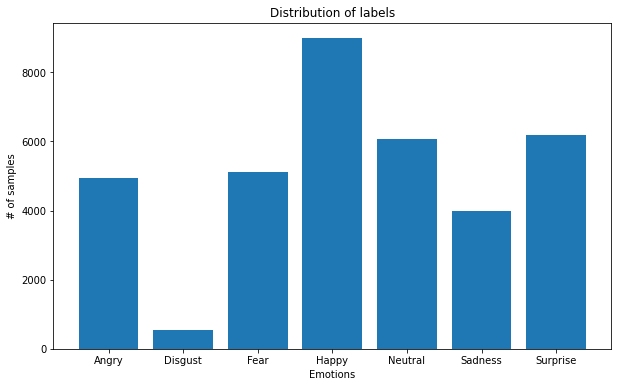

In [24]:
plt.figure(figsize=(10,6))
plt.bar(CLASS_LABELS, [df['emotion'].tolist().count(i) for i in np.arange(NUM_CLASSES)])
plt.xlabel('Emotions')
plt.ylabel('# of samples')
plt.title('Distribution of labels')
plt.show()

In [25]:
# Transform df column with pixels into a pytorch tensor
pixels = df['pixels']
pixels = pixels.apply(lambda x: x.split(" ")).tolist()
pixels = np.uint8(pixels)
pixels = torch.Tensor(pixels)
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48))

In [26]:
pixels.shape

torch.Size([35887, 1, 48, 48])

In [27]:
train_idx = df.index[df['Usage'] == 'Training'].tolist()     # 28709
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist()   # 3589
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist()  # 3589

In [28]:
len(train_idx)



28709

In [29]:
X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())

X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())

X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())

In [95]:
y_val

tensor([0., 1., 4.,  ..., 4., 4., 4.])

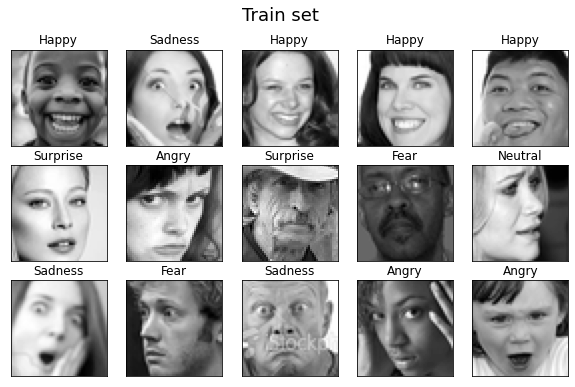

In [30]:
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_train[5*i+j+8188].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_train[5*i+j+8188])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Train set', fontsize=18)
plt.show()

In [31]:
class tensorDataset(Dataset):
    '''
    Inputs:
    - images: a (Batch size, Channels, Height, Width) tensor
    - labels: a 1-dimensional tensor corresponding to image labels
    - train: True if you want to apply transformations, False otherwise
    '''
    
    def __init__(self, images, labels, train:bool):
        self.images = images/255
        self.labels = labels
        self.train  = train
        

    def __getitem__(self, index):
        
        # Load the image (as tensor)
        img  = self.images[index]
        label = self.labels[index]
        
        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        
        return img, label

    
    def __len__(self):
        return len(self.images)
    
    
    def transform(self, img):
      
        # Horizontal flip
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)

        # Add rotations
        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [32]:
def create_dataloaders(batch_size, X_train, y_train, X_val, y_val, X_test=None, y_test=None):

    train_dataset = tensorDataset(X_train, y_train, train=True)
    val_dataset   = tensorDataset(X_val, y_val, train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

    if X_test is not None:
        test_dataset  = tensorDataset(X_test, y_test, train=False)
        test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
        return train_dataloader, val_dataloader, test_dataloader
    
    return train_dataloader, val_dataloader

In [83]:
class ED_model(nn.Module):
    def __init__(self, in_channels=1, out_channels=7):
        super(ED_model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 


        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
     

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout4 = nn.Dropout(p=0.1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)


        self.conv6 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm2d(64)
        self.max_pool6 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout6 = nn.Dropout(p=0.1)



    

        self.fc1 = nn.Linear(in_features=6*6*64, out_features=1024)
        self.dropout7 = nn.Dropout(p=0.1)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.dropout8 = nn.Dropout(p=0.1)
        self.bn8 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, out_channels)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.max_pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
     


        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.max_pool4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
  

        x = self.conv6(x)
        x = self.relu6(x)
        x = self.bn6(x)
        x = self.max_pool6(x)
        x = self.dropout6(x)



        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout7(x)
        x = self.bn7(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout8(x)
        x = self.bn8(x)
        x = self.fc3(x)
        
        x = F.softmax(x, dim=1)

        return x

In [84]:
# class ED_model2(nn.Module):
#     def __init__(self, in_channels=1, out_channels=7):
#         super(ED_model, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding='same', bias=False)
#         self.relu1 = nn.ReLU()
#         self.conv11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same', bias=False)
#         self.relu11 = nn.ReLU()
#         self.bn1 = nn.BatchNorm2d(64)
#         self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
#         self.dropout1 = nn.Dropout(p=0.3)

   


#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding='same', bias=False)
#         self.relu2 = nn.ReLU()
#         self.bn2 = nn.BatchNorm2d(128)
#         self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
#         self.dropout2 = nn.Dropout(p=0.3)


#         self.conv3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding='same', bias=False)
#         self.relu3 = nn.ReLU()
#         self.bn3 = nn.BatchNorm2d(512)
#         self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 
#         self.dropout3 = nn.Dropout(p=0.3)


#         self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same', bias=False)
#         self.relu4 = nn.ReLU()
#         self.bn4 = nn.BatchNorm2d(512)
#         self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 
#         self.dropout4 = nn.Dropout(p=0.3)


#         self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding='same', bias=False)
#         self.relu5 = nn.ReLU()
#         self.bn5 = nn.BatchNorm2d(512)
#         self.max_pool5 = nn.MaxPool2d(kernel_size=2, stride=2) 
#         self.dropout5 = nn.Dropout(p=0.3)
     




    

#         self.fc1 = nn.Linear(in_features=1*1*512, out_features=256)
#         self.bn6 = nn.BatchNorm1d(256)
#         self.dropout6 = nn.Dropout(p=0.3)


#         self.fc2 = nn.Linear(in_features=256, out_features=512)
#         self.bn7 = nn.BatchNorm1d(512)
#         self.dropout7 = nn.Dropout(p=0.3)



#         self.fc3 = nn.Linear(512, out_channels)


#     def forward(self, x):

#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv11(x)
#         x = self.relu11(x)
#         x = self.bn1(x)
#         x = self.max_pool1(x)
#         x = self.dropout1(x)


#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.bn2(x)
#         x = self.max_pool2(x)
#         x = self.dropout2(x)


#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.bn3(x)
#         x = self.max_pool3(x)
#         x = self.dropout3(x)


#         x = self.conv4(x)
#         x = self.relu4(x)
#         x = self.bn4(x)
#         x = self.max_pool4(x)
#         x = self.dropout4(x)

#         x = self.conv5(x)
#         x = self.relu5(x)
#         x = self.bn5(x)
#         x = self.max_pool5(x)
#         x = self.dropout5(x)

        

      
  

      


#         x = torch.flatten(x, start_dim=1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.bn6(x)
#         x = self.dropout6(x)


#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.bn7(x)
#         x = self.dropout7(x)


        
#         x = self.fc3(x)
        
#         x = F.softmax(x, dim=1)

#         return x

In [85]:
from torchinfo import summary


model = ED_model(in_channels=1, out_channels=NUM_CLASSES)
# summary(model, input_size=(99, 1, 48, 48))

In [86]:
def train():

    for epoch in range(1, EPOCHS+1):

        # Train model
        model.train()
        train_losses   = []
        train_accuracy = []
        train_f1       = []

        for i, batch in enumerate(train_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Train model
            optimizer.zero_grad()
            output = model(img_batch) # output: [B, 7, H, W]
            loss   = criterion(output, label_batch)
            loss.backward()
            optimizer.step()

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            train_losses.append(loss.item())
            train_accuracy.append(acc.cpu())
            train_f1.append(f1)
            # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}, learning rate: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')        
        total_train_losses.append(np.mean(train_losses))
        total_train_accuracy.append(np.mean(train_accuracy))
        total_train_f1.append(np.mean(train_f1))

        #Update learning rate
        learning_rate_tracker.append(optimizer.state_dict()['param_groups'][0]['lr'])
        scheduler.step()

        # Validate model
        model.eval()
        val_losses   = []
        val_accuracy = []
        val_f1       = []

        for i, batch in enumerate(val_dataloader):
            #Extract data, labels
            img_batch, label_batch = batch
            img_batch = img_batch.to(DEVICE)
            label_batch = label_batch.type(torch.LongTensor).to(DEVICE)

            #Validate model
            with torch.cuda.amp.autocast():
                output = model(img_batch)
                loss   = criterion(output, label_batch)

            #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            preds = torch.argmax(output, dim=1)
            f1 = f1_score(preds.cpu(), label_batch.cpu(), average='macro')
            acc = torch.sum(preds == label_batch) / len(preds)
            val_losses.append(loss.item())
            val_accuracy.append(acc.cpu())
            val_f1.append(f1)
            # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')

        # Update global metrics
        print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
        print('-'*106)
        total_val_losses.append(np.mean(val_losses))
        total_val_accuracy.append(np.mean(val_accuracy))
        total_val_f1.append(np.mean(val_f1))


        # Save the results so far
        temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
        temp_df.to_csv('train_val_measures')

In [87]:
torch.cuda.is_available()

True

In [88]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
LR = 0.0001
BATCH_SIZE = 64

model = ED_model(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(BATCH_SIZE, X_train, y_train, X_val, y_val, X_test, y_test)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) # Use dynamic learning rate
criterion = nn.CrossEntropyLoss().to(DEVICE)

total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []
learning_rate_tracker = []

In [89]:
train()


TRAIN       Epoch: 1 | Epoch metrics | loss: 1.7886, f1: 0.283, accuracy: 0.365, learning rate: 0.000100
VALIDATION  Epoch: 1 | Epoch metrics | loss: 1.7040, f1: 0.354, accuracy: 0.456
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.7033, f1: 0.371, accuracy: 0.453, learning rate: 0.000100
VALIDATION  Epoch: 2 | Epoch metrics | loss: 1.6742, f1: 0.396, accuracy: 0.484
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.6654, f1: 0.414, accuracy: 0.492, learning rate: 0.000100
VALIDATION  Epoch: 3 | Epoch metrics | loss: 1.6668, f1: 0.394, accuracy: 0.487
----------------------------------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 1.6409, f1: 0.435, accuracy: 0.518, learning rate: 0.000100
VALIDATION  Epoch: 

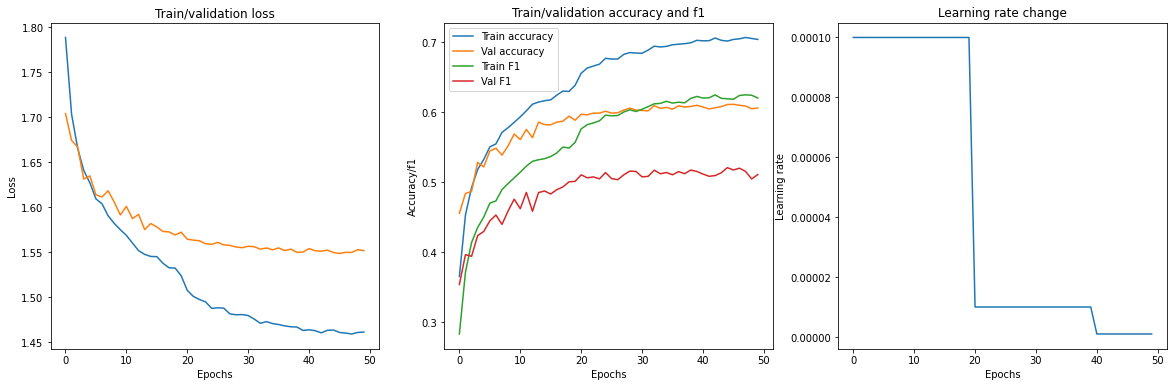

In [90]:
f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(list(range(len(total_train_losses))), total_train_losses)
axarr[0].plot(list(range(len(total_train_losses))), total_val_losses)
axarr[0].set_title('Train/validation loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(list(range(len(total_train_accuracy))), total_train_accuracy, label='Train accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_accuracy, label='Val accuracy')
axarr[1].plot(list(range(len(total_train_accuracy))), total_train_f1, label='Train F1')
axarr[1].plot(list(range(len(total_train_accuracy))), total_val_f1, label='Val F1')
axarr[1].set_title('Train/validation accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(learning_rate_tracker)), learning_rate_tracker)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')
plt.show()

In [91]:
# model = ED_model(in_channels=1, out_channels=NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load('/content/ED_model.pt'))

preds = []
labels = []

for img_batch, label_batch in val_dataloader:
    img_batch = img_batch.to(DEVICE)
    output = model(img_batch)

    labels.extend(label_batch.type(torch.uint8).tolist())
    preds.extend(torch.argmax(output, dim=1).tolist())

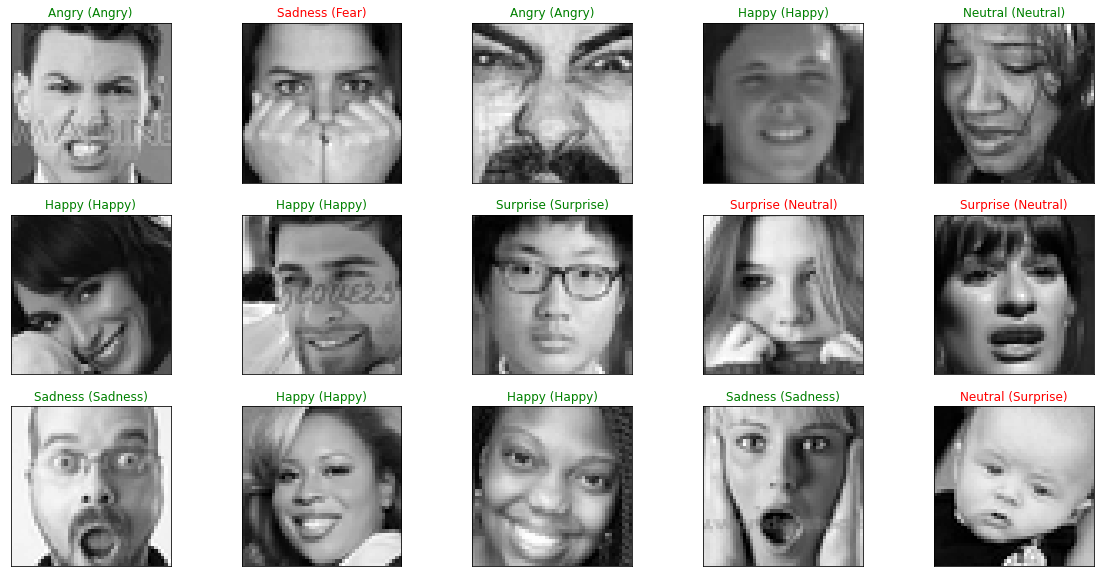

In [92]:
f, axarr = plt.subplots(3,5, figsize=(20,10))

for i in range(3):
    for j in range(5):
        const = np.random.randint(0, len(labels)-15)
        idx = const + i*5+j
        axarr[i,j].imshow(X_val[idx].squeeze(), cmap='gray')
        axarr[i,j].set_title(f'{label_dict[preds[idx]]} ({label_dict[labels[idx]]})', color=('green' if preds[idx]==labels[idx] else 'red'))
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])

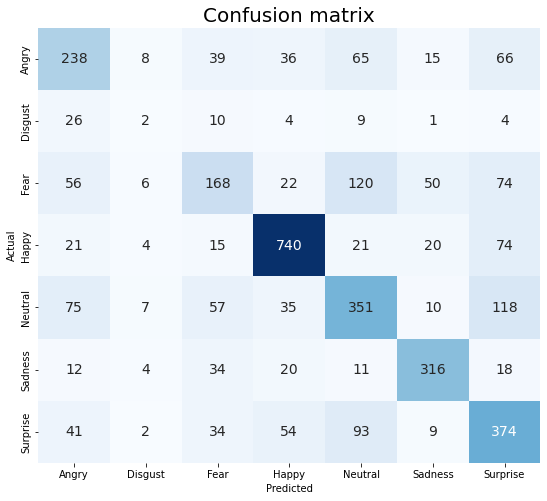

In [93]:
import seaborn as sns
cm_data = confusion_matrix(labels, preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

plt.figure(figsize=(9,8))
plt.title('Confusion matrix', fontsize=20)
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, annot_kws={'size':14}, fmt='g')
plt.show()

In [94]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.507     0.510     0.509       467
           1      0.061     0.036     0.045        56
           2      0.471     0.339     0.394       496
           3      0.812     0.827     0.819       895
           4      0.524     0.538     0.531       653
           5      0.751     0.761     0.756       415
           6      0.514     0.616     0.560       607

    accuracy                          0.610      3589
   macro avg      0.520     0.518     0.516      3589
weighted avg      0.604     0.610     0.604      3589

